# 3 Preprocessing Data<a id='3'></a>

## 3.1 Contents<a id='3.1'></a>
* [3 Preprocessing Data](#3)
    * [3.1 Contents](#3.1)
    * [3.2 Introduction](#3.2)
    * [3.3 Imports](#3.3)
    * [3.4 Load the Cleaned Data](#3.4)
    * [3.5 Train Test Split](#3.5)
    * [3.6 Preprocessing Columns](#3.6)
    * [3.7 Define Column groups](#3.7)
        * [3.6.1 Column Selector](#3.6.1)
        * [3.6.2 Mode Imputer](#3.6.2)
    * [3.7 Pipeline](#3.7)
        * [3.7.1 Categorical Pipeline](#3.7.1)
        * [3.7.2 Ordinal Pipeline](#3.7.2)
        * [3.7.3 Age Distance Pipeline](#3.7.3)
        * [3.7.4 Wait Times Pipeline](#3.7.4)
    * [3.8 Feature union](#3.8)
    * [3.9 Checking Steps](#3.9)
        * [3.9.1 Fit Transform Training Data Check](#3.9.1)
        * [3.9.2 Transform Test Data Check](#3.9.2)
    * [3.10 Modeling](#3.10)
        * [3.10.1 Baseline Model](#3.10.1)
        * [3.10.2 Logistic Regression Model](#3.10.2)

## 3.2 Introduction<a id='3.2'></a>

We've divided the data into Categorical, Ordinal Continuous and Continuous Variables

## 3.3 Imports<a id='3.3'></a>

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## 3.4 Load the Cleaned data<a id='3.4'></a>

In [3]:
raw_data_clean = pd.read_csv('../data/interim/raw_data_clean.csv')

In [4]:
#Preview the data
pd.set_option('display.max_columns', None)
with pd.option_context('display.max_rows',10):
    display(raw_data_clean)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,94171,Female,disloyal Customer,23,Business travel,Eco,192,2,1,2,3,2,2,2,2,3,1,4,2,3,2,3,0.0,0
103900,73097,Male,Loyal Customer,49,Business travel,Business,2347,4,4,4,4,2,4,5,5,5,5,5,5,5,4,0,0.0,1
103901,68825,Male,disloyal Customer,30,Business travel,Business,1995,1,1,1,3,4,1,5,4,3,2,4,5,5,4,7,14.0,0
103902,54173,Female,disloyal Customer,22,Business travel,Eco,1000,1,1,1,5,1,1,1,1,4,5,1,5,4,1,0,0.0,0


## 3.5 Train Test Split<a id='3.5'></a>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_clean.drop(columns = ['satisfaction', 'id']),
                                                    raw_data_clean.satisfaction,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [6]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(83123, 22) (83123,)
(20781, 22) (20781,)


## 3.6 Preprocessing Columns<a id='3.6'></a>

We need to create pipelines for the categorical columns, ordinal columns and continuous columns since each one of them will have different transformations

In [7]:
categorical_cols = ['Gender', 'Type of Travel', 'Class', 'Customer Type']
ordinal_cols = list(raw_data_clean.loc[:, 'Inflight wifi service': 'Cleanliness'].columns)
continuous_cols_1 = ['Age', 'Flight Distance']
continuous_cols_2 = ['Departure Delay in Minutes', 'Arrival Delay in Minutes']

### 3.6.1 Column Selector<a id='3.6.1'></a>

In [8]:
# Define custom transformer
class ColumnSelector(BaseEstimator, TransformerMixin):
    """Select only specified columns."""
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

### 3.6.2 Mode Imputer<a id='3.6.2'></a>

We need to define a mode imputer to impute Categorical variables with the most frequent occurance

This solution has been adapted from the stackoverflow link: <a href = 'https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn'>Mode Imputer Stack Over Flow</a>

In [9]:
class ModeImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

## 3.7 Pipeline<a id='3.7'></a>

### 3.7.1 Categorical Pipeline<a id='3.7.1'></a>

In [10]:
cat_pipe = Pipeline([('selector', ColumnSelector(categorical_cols)),
                     ('imputer', ModeImputer()),
                     ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

### 3.7.2 Ordinal Pipeline<a id='3.7.2'></a>

In [11]:
ord_pipe = Pipeline([('selector', ColumnSelector(ordinal_cols)),
                     ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
                     ('scaler', MinMaxScaler())])

### 3.7.3 Continous Cols Age Distance Pipeline<a id='3.7.3'></a>

In [12]:
cont_1_pipe = Pipeline([('selector', ColumnSelector(continuous_cols_1)),
                     ('imputer', SimpleImputer(strategy = 'mean')),
                     ('scaler', StandardScaler())])

#### 3.7.4 Continous Cols Wait Times Pipeline<a id='3.7.4'></a>

In [13]:
cont_2_pipe = Pipeline([('selector', ColumnSelector(continuous_cols_2)),
                     ('imputer', SimpleImputer(strategy = 'constant', fill_value = 0)),
                     ('scaler', PowerTransformer())])

## 3.8 Feature union<a id='3.8'></a>

In [14]:
# Fit feature union to training data
preprocessor = FeatureUnion(transformer_list=[('cat', cat_pipe),
                                              ('ord', ord_pipe),
                                              ('cont_1', cont_1_pipe),
                                              ('cont_2', cont_2_pipe)])
preprocessor.fit(X_train)

FeatureUnion(transformer_list=[('cat',
                                Pipeline(steps=[('selector',
                                                 ColumnSelector(columns=['Gender',
                                                                         'Type '
                                                                         'of '
                                                                         'Travel',
                                                                         'Class',
                                                                         'Customer '
                                                                         'Type'])),
                                                ('imputer',
                                                 <__main__.ModeImputer object at 0x000001D441CCB430>),
                                                ('encoder',
                                                 OneHotEncoder(handle_unknown='ignore',
            

## 3.9 Checking Steps<a id='3.9'></a>

In [15]:
# Prepare column names
cat_columns = preprocessor.transformer_list[0][1]['encoder'].get_feature_names(categorical_cols)
columns = np.append(np.append(np.append(cat_columns, ordinal_cols), continuous_cols_1), continuous_cols_2)

### 3.9.1 Fit Transform Training Data Check<a id='3.9.1'></a>

In [16]:
# Inspect training data before and after
print("******************** Training data ********************")
display(X_train.head())
display(pd.DataFrame(preprocessor.transform(X_train), columns=columns).head())

******************** Training data ********************


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
20921,Female,Loyal Customer,59,Personal Travel,Eco,1046,4,5,4,1,5,4,5,2,2,4,3,5,2,4,12,3.0
36897,Female,disloyal Customer,40,Business travel,Business,752,4,4,4,2,1,4,5,1,4,2,4,3,5,1,19,29.0
8468,Male,Loyal Customer,65,Personal Travel,Eco,383,2,3,2,1,1,2,1,1,5,4,5,5,5,1,0,0.0
53490,Female,Loyal Customer,70,Personal Travel,Eco,2239,3,5,3,4,3,5,4,5,5,3,5,3,5,5,0,0.0
78687,Female,disloyal Customer,25,Business travel,Eco,1358,2,2,2,3,1,2,1,1,1,2,3,5,2,1,3,15.0


,Gender_Female,Gender_Male,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.8,1.0,0.8,0.2,1.0,0.8,1.0,0.4,0.4,0.8,0.50,1.0,0.4,0.8,1.299867,-0.143103,1.108393,0.469005
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.8,0.8,0.8,0.4,0.2,0.8,1.0,0.2,0.8,0.4,0.75,0.6,1.0,0.2,0.043551,-0.438007,1.255946,1.348095
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.4,0.6,0.4,0.2,0.2,0.4,0.2,0.2,1.0,0.8,1.00,1.0,1.0,0.2,1.696598,-0.808142,-0.836089,-0.841936
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,1.0,0.6,0.8,0.6,1.0,0.8,1.0,1.0,0.6,1.00,0.6,1.0,1.0,2.027207,1.053565,-0.836089,-0.841936
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.4,0.4,0.4,0.6,0.2,0.4,0.2,0.2,0.2,0.4,0.50,1.0,0.4,0.2,-0.948277,0.169856,0.503068,1.155986


### 3.9.2 Transform Test Data Check<a id='3.9.2'></a>

In [17]:
# Inspect test data before and after
print("******************** Test data ********************")
display(X_test.head())

******************** Test data ********************


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
80638,Female,Loyal Customer,26,Personal Travel,Eco,861,2,4,2,5,5,2,5,5,5,4,4,3,5,5,0,0.0
43398,Male,Loyal Customer,22,Business travel,Business,393,3,5,5,5,3,3,3,3,1,1,3,2,3,3,0,16.0
32751,Female,Loyal Customer,59,Personal Travel,Eco,196,1,3,1,3,2,3,3,4,4,1,4,3,4,4,37,34.0
33571,Female,Loyal Customer,32,Personal Travel,Eco,1020,2,3,2,4,4,2,4,4,3,2,4,1,4,4,27,4.0
71287,Male,disloyal Customer,35,Business travel,Business,1117,2,2,2,1,2,2,5,2,2,2,3,2,2,2,0,0.0


In [18]:
print("******************** Transformed Test data ********************")
display(pd.DataFrame(preprocessor.transform(X_test), columns=columns).head())

******************** Transformed Test data ********************


,Gender_Female,Gender_Male,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Age,Flight Distance,Departure Delay in Minutes,Arrival Delay in Minutes
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.4,0.8,0.4,1.0,1.0,0.4,1.0,1.0,1.0,0.8,0.75,0.6,1.0,1.0,-0.882155,-0.328672,-0.836089,-0.841936
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.6,1.0,1.0,1.0,0.6,0.6,0.6,0.6,0.2,0.2,0.50,0.4,0.6,0.6,-1.146642,-0.798111,-0.836089,1.177061
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.2,0.6,0.2,0.6,0.4,0.6,0.6,0.8,0.8,0.2,0.75,0.6,0.8,0.8,1.299867,-0.995717,1.425504,1.387217
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.4,0.6,0.4,0.8,0.8,0.4,0.8,0.8,0.6,0.4,0.75,0.2,0.8,0.8,-0.485424,-0.169183,1.351432,0.611590
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.4,0.4,0.4,0.2,0.4,0.4,1.0,0.4,0.4,0.4,0.50,0.4,0.4,0.4,-0.287058,-0.071885,-0.836089,-0.841936


## 3.10 Modeling<a id='3.10'></a>

### 3.10.1 Baseline Model<a id='3.10.1'></a>

In [19]:
# Combine categorical and numerical pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', DummyClassifier())])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [0 0 0 ... 0 0 0]
Predictions on test data: [0 0 0 ... 0 0 0]


In [20]:
print(confusion_matrix(y_test, y_test_pred))
print(f'Baseline Model score {round(accuracy_score(y_test, y_test_pred) * 100, 2)}%' )

[[11713     0]
 [ 9068     0]]
Baseline Model score 56.36%


### 3.10.2 LogisticRegression Model<a id='3.10.2'></a>

In [21]:
# Combine categorical and numerical pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', LogisticRegression())])
pipe.fit(X_train, y_train)

# Predict training data
y_train_pred = pipe.predict(X_train)
print(f"Predictions on training data: {y_train_pred}")

# Predict test data
y_test_pred = pipe.predict(X_test)
print(f"Predictions on test data: {y_test_pred}")

Predictions on training data: [0 0 0 ... 0 1 0]
Predictions on test data: [0 0 0 ... 0 1 1]


c:\users\neel deorukhkar\documents\springboardprojects\capstone2\predict_customer_sat\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
print(confusion_matrix(y_test, y_test_pred))
print(f'Logistic Regression Model score {round(accuracy_score(y_test, y_test_pred) * 100, 2)}%' )
print(classification_report(y_test, y_test_pred))

[[10627  1086]
 [ 1458  7610]]
Logistic Regression Model score 87.76%
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     11713
           1       0.88      0.84      0.86      9068

    accuracy                           0.88     20781
   macro avg       0.88      0.87      0.87     20781
weighted avg       0.88      0.88      0.88     20781



### 3.10.3 Decision Tree Modeling <a id='3.10.3'></a>

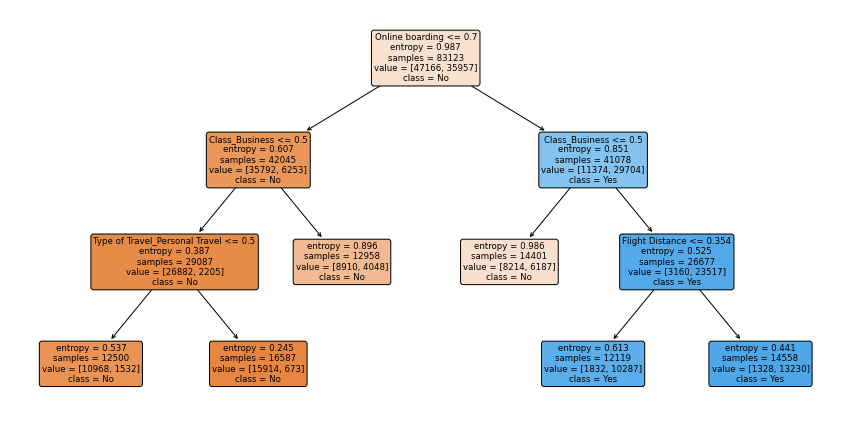

In [65]:
## NOTE: We can plot the tree and it is huge!
X_train_dt = pd.DataFrame(preprocessor.transform(X_train), columns=columns)
clf_dt = DecisionTreeClassifier(random_state=42, min_samples_leaf= 12000, min_samples_split=25000, criterion='entropy')
clf_dt.fit(X_train_dt, y_train)

plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["No", "Yes"], 
          feature_names=columns); 

### 3.10.4 Random Forest Feature Importance <a id='3.10.4'></a>

In [69]:
clf_rf = RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=500)
clf_rf.fit(X_train_dt, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=500)

27


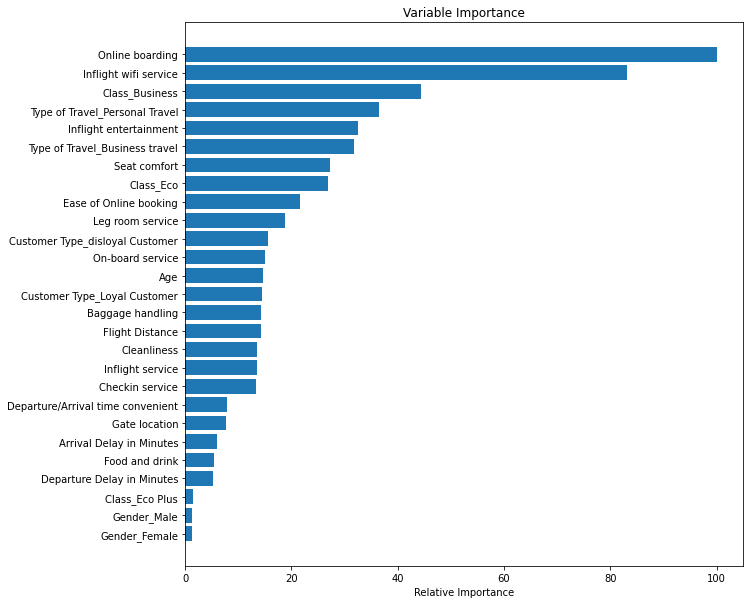

In [70]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_dt.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()